In [12]:
import sys
from fancy_einsum import einsum

import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformers import AutoTokenizer, pipeline, logging, AutoModelForCausalLM, AutoConfig
from transformer_lens import ActivationCache, HookedTransformer

from huggingface_hub import notebook_login
from datasets import Dataset
import pandas as pd
import transformers
import torch
import einops  # Make sure einops is imported
import numpy as np 

from neel_plotly import line, imshow, scatter
import transformer_lens.patching as patching
import circuitsvis as cv
import matplotlib.pyplot as plt
from pathlib import Path
# Import from local libraries

from utils import *

from sklearn.neighbors import NearestNeighbors
from sklearn import linear_model
# Method to calculate ID
import argparse
import json


In [13]:

def get_ratios(vectors, n_neighbors):
    try:
        N = len(vectors)
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="auto").fit(vectors)
        distances, indices = nbrs.kneighbors(vectors)
        ratios = np.array(
            [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
        )

    except Exception as e:
        print(f"An error occurred: {e}")
        ratios = None
        N = 0

    return ratios, N, distances[:, 1:n_neighbors]


def measure_dimension_kNN(
    vectors, n_neighbors=5, fraction=0.9, plot=False, verbose=False
):
    ratios, N = get_ratios(vectors, n_neighbors)
    try:
        mus = [
            np.sort(ratios[i], axis=None, kind="quicksort") for i in range(n_neighbors - 2)
        ]
        Femp = (np.arange(1, N + 1, dtype=np.float64)) / N

        dims = []
        xs = []
        ys = []
        regrs =[]
        for k, mu in enumerate(mus):
            x = np.log(mu[:-2])
            xs += [x]
            y = -np.log(1 - Femp[:-2] ** (1 / (k + 1)))
            ys += [y]

            npoints = int(np.floor(N * fraction))
            regr = linear_model.LinearRegression(fit_intercept=False)
            regr.fit(x[:npoints, np.newaxis], y[:npoints, np.newaxis])
            if verbose:
                print(
                    "From ratio " + str(k + 2) + " NN estimated dim " + str(regr.coef_[0])
                )
            dims += [regr.coef_[0]]
            regrs += [regr]

        if plot:
            fig, ax = plt.subplots(figsize=(7, 7))
            ax.set_title("Log F vs Log mu")
            ax.set_xscale("linear")
            ax.set_yscale("linear")
            for x, y, dim, regr in zip(xs, ys, dims, regrs):
                ax.scatter(x[:npoints], y[:npoints])
                ax.plot(
                    x[:npoints], regr.predict(x[:npoints].reshape((-1, 1))), color="gray"
                )
                ax.text(x[0],y[0], f'Dim {dim}', fontsize=14, color='blue')
        else : 
            fig = None
        #print(x[:npoints],regr.predict(x[:npoints].reshape((-1, 1)) ))
        return xs, ys, dims, regrs, npoints, fig
    except:
        return None, None, None, None, None, None


def measure_dimension_MLE(vectors, n_neighbors=10, plot=False, verbose=False):
    ratios, _ = get_ratios(vectors, n_neighbors)
    logs = np.log(ratios)
    estimates = (n_neighbors - 2) / (logs[:, -1] - np.sum(logs[:, :-1], axis=1))
    dim = np.mean(estimates)
    var = np.var(estimates)
    if verbose:
        print("Dimension MLE: ", dim, " Stddev: ", np.sqrt(var))
    if plot:
        fig, axs = plt.subplots(1, 1)
        axs.hist(estimates, bins=50)

    return dim, var, estimates

if True:
    last_idxs= torch.load(Path(project_name)/'last_idxs.pt')
    
    import itertools
    import pickle
    from sklearn.neighbors import NearestNeighbors
    from sklearn import linear_model
    
    # Use itertools.product to create combinations
    last_token_ind=1023
    fraction=0.1
    keys=[]
    dims_dict={}
    # Print each combination
    for str_i,str_j in list(itertools.product(names_filter, final_activations.keys()))[:]:
        key=f"{str_i}.{str_j}"
        file=key+".pt"
        activation_tensors0 = torch.load(Path(project_name)/file)
        filtered_data_idx=(np.array(last_idxs)==last_token_ind)
        activation_tensors_filtered=activation_tensors0[filtered_data_idx,:]

        xs, ys, dims, regrs, npoints, fig = measure_dimension_kNN(
            activation_tensors_filtered, n_neighbors=5, fraction=fraction, plot=True, verbose=True
        )

        if fig is not None:
            fig.savefig(Path(project_name) / ('plot_ID_'+file.replace(".pt", ".png")))

        dims_dict[key]=dims
        keys+=[key]

    Dimension_analyzed={
        "positions" :list(final_activations.keys()),
        "layer_keys" :target_layers_substrings,
        "layer_ind":layer_indices,
        "names_filter" : names_filter,
        "keys":keys,
        "dims":dims_dict,
        "last_token_ind":last_token_ind,
        "filtered_data_idx":filtered_data_idx,
        "fraction":fraction,
        "sample_num" : len(filtered_data_idx),
        "filtered_sample_num": sum(filtered_data_idx)
    }

    with open(Path(project_name)/'Dimension_analyzed.pkl', 'wb') as f:
        pickle.dump(Dimension_analyzed, f)



NameError: name 'project_name' is not defined

In [ ]:
parser = argparse.ArgumentParser(description='Run model with dataset.')

parser.add_argument('--session_name', type=str, required=True, help='Name of the session')
parser.add_argument('--model_name', type=str, required=True, help='Name of the model')
parser.add_argument('--model_checkpoint', type=str, required=True, help='Checkpoint of the model')
parser.add_argument('--dataset_name', type=str, required=True, help='Name of the dataset')
parser.add_argument('--dataset_subset', type=int, nargs='*', required=True, help='Subset of the dataset')
parser.add_argument('--tokens_min_length', type=int, required=True, help='Minimum length of tokens in the dataset')

#args = parser.parse_args()
#print(args)

#main("test", model_name="olmo-1b", model_checkpoint="main", dataset_name='pile_uncopyrighted_parquet', dataset_subset=[0,1], tokens_min_length=1024)
class Args:
    session_name = "20240619_231648_cacheingAllLong_olmo-1b_main_pile_uncopyrighted_parquet_0"
    model_name = "olmo-1b"
    model_checkpoint = "main"
    dataset_name = 'pile_uncopyrighted_parquet'
    dataset_subset = [0, 1]
    tokens_min_length = 1024

args = Args()

In [46]:
from pathlib import Path
def load_cacheAll_from_file(file_path, dim1, dim2=None, dtype=torch.float32, num_elements=None):
    tensors = []
    elements_read = 0

    with open(file_path, 'rb') as f:
        while True:
            if num_elements is not None and elements_read >= num_elements:
                break

            len_bytes = f.read(4)
            if not len_bytes:
                break

            length = int.from_bytes(len_bytes, byteorder='big')
            tensor_bytes = f.read(length)
            tensor = np.frombuffer(tensor_bytes, dtype=np.float32)
            if dim2 is not None:
                tensor = tensor.reshape(-1, dim1, dim2)
            else:
                tensor = tensor.reshape(-1, dim1)
            tensors.append(tensor)
            elements_read += tensor.size // (dim1 * (dim2 if dim2 is not None else 1))

            if num_elements is not None and elements_read >= num_elements:
                tensors[-1] = tensors[-1][:num_elements - (elements_read - tensor.size // (dim1 * (dim2 if dim2 is not None else 1)))]
                break
    return np.concatenate(tensors)


session_path = Path(f"Data/{args.session_name}")  # Update this to your desired path

with open(session_path / 'config.json', 'r') as f:
    config=json.load(f)

d_model=2048
ctx_len=2048
num_elements=30
CREloss=load_cacheAll_from_file(session_path / 'CREloss.pt', ctx_len-1,num_elements=num_elements)[13:20]
Entropy=load_cacheAll_from_file(session_path / 'Entropy.pt', ctx_len-1,num_elements=num_elements)[13:20]
metadata=pd.read_csv(session_path/'metadata.csv')[13:20]

layer_idx=15
module_name="ln_f"
if module_name == "ln_f":
    fpath=f"model_transformer_{module_name}_all.pt"
elif module_name is None:
    fpath=f"model_transformer_blocks_{layer_idx}_all.pt"
else:
    fpath=f"model_transformer_blocks_{layer_idx}_{module_name}_all.pt"


vectors=load_cacheAll_from_file(session_path / fpath, ctx_len, d_model,num_elements=num_elements)[13:20]

In [47]:
vectors.shape

(7, 2048, 2048)

In [65]:
# Specify the number of slices to select from the first dimension
num_slices = 5  # for example, you want to select the first 3 slices

# Step 1: Select the desired slices from the first dimension
selected_vectors = vectors[:num_slices,256:,:]

# Step 2: Concatenate the selected slices along the first dimension
# (this is already the case since we sliced the tensor)
# No need for additional concatenation step as slicing effectively selects the slices

# Step 3: Reshape to flatten the first two dimensions
flattened_vectors = selected_vectors.reshape(-1, 2048)


#filtered_idx=(metadata[metadata['len'] >= pos].index.tolist())
Data={}
Data['vectors']=flattened_vectors
#Data['entropy']=Entropy[filtered_idx,pos]
#Data['loss']=CREloss[filtered_idx,pos]

In [66]:
fraction=1
n_neighbors=5
plot=True
verbose=True

In [67]:
Data['vectors'].shape

(8960, 2048)

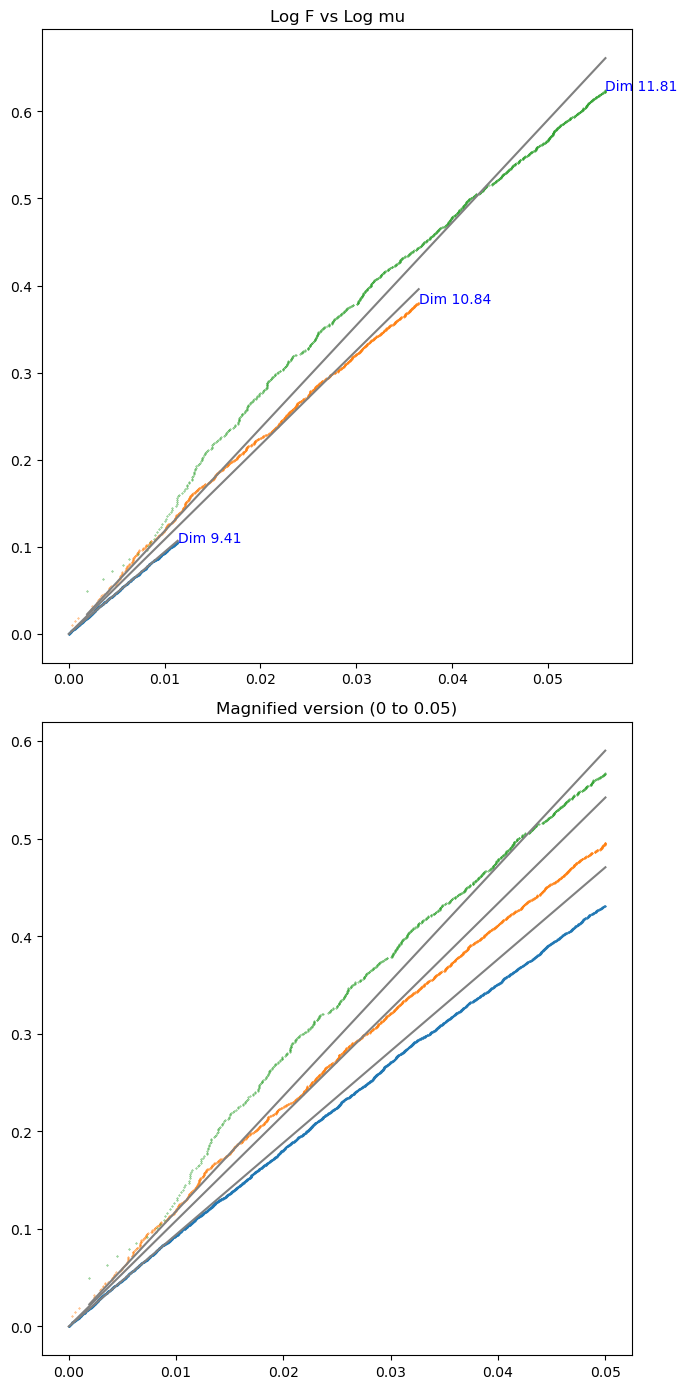

In [68]:
fraction=0.1
ratios, N, distances = get_ratios(Data['vectors'], n_neighbors)
# Existing Code
try:
    mus = [np.sort(ratios[i], axis=None, kind="quicksort") for i in range(n_neighbors- 2)]
    Femp = (np.arange(1, N + 1, dtype=np.float64)) / N

    dims = []
    xs = []
    ys = []
    regrs = []
    for k, mu in enumerate(mus):
        x = np.log(mu[:-2])
        xs += [x]
        y = -np.log(1 - Femp[:-2] ** (1 / (k + 1)))
        ys += [y]

        npoints = int(np.floor(N * fraction))
        regr = linear_model.LinearRegression(fit_intercept=False)
        regr.fit(x[:npoints, np.newaxis], y[:npoints, np.newaxis])
        dims += [regr.coef_[0]]
        regrs += [regr]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 14))
    ax1.set_title("Log F vs Log mu")
    ax1.set_xscale("linear")
    ax1.set_yscale("linear")
    for x, y, dim, regr in zip(xs, ys, dims, regrs):
        ax1.scatter(x[:npoints], y[:npoints], s=0.1)
        ax1.plot(x[:npoints], regr.predict(x[:npoints].reshape((-1, 1))), color="gray")
        ax1.text(x[npoints-1], y[npoints-1], f'Dim {dim[0]:.2f}', fontsize=10, color='blue')

    ax2.set_title("Magnified version (0 to 0.05)")
    ax2.set_xscale("linear")
    ax2.set_yscale("linear")
    for x, y, dim, regr in zip(xs, ys, dims, regrs):
        mask = x <= 0.05
        ax2.scatter(x[mask], y[mask], s=0.1)
        ax2.plot(x[mask], regr.predict(x[mask].reshape((-1, 1))), color="gray")
        #if len(x[mask]) > 0 and len(y[mask]) > 0:
            #ax2.text(x[mask][-1], y[mask][-1], f'Dim {dim[0]:.2f}', fontsize=14, color='blue')

    plt.tight_layout()
    plt.show()
except Exception as e:
    print("exception", e)

(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        4.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 3.000e+00, 4.000e+00,
        2.000e+00, 3.000e+00, 5.000e+00, 4.000e+00, 6.000e+00, 9.000e+00,
        1.000e+01, 1.700e+01, 2.300e+01, 3.000e+01, 3.900e+01, 5.900e+01,
        4.000e+01, 6.100e+01, 5.900e+01, 8.100e+01, 1.110e+02, 1.120e+02,
        1.420e+02, 1.440e+02, 1.870e+02, 1.860e+02, 2.050e+02, 2.320e+02,
        2.350e+02, 2.680e+02, 2.580e+02, 2.870e+02, 2.890e+02, 3.200e+02,
        3.270e+02, 3.460e+02, 3.480e+02, 3.890e+02, 4.280e+02, 4.090e+02,
        4.800e+02, 5.110e+02, 5.180e+02, 6.540e+02, 7.220e+02, 8.370e+02,
        9.120e+02, 9.610e+02, 9.840e+02, 1.045e+03, 1.133e+03, 1.100e+03,
        1.225e+03, 1.190e+03, 1.175e+03, 1.119e+03, 9.350e+02, 1.023e+03,
        9.070e+02, 8.270e+02, 7.480e+02, 6.340e+02, 5.870e+02, 5.540e+02,
        4.430e+02, 3.310e+02, 2.750e+02, 2.230e+02, 1.800e+02, 1.300e+02,
        8.700e+01, 6.900e+01, 4.700e+0

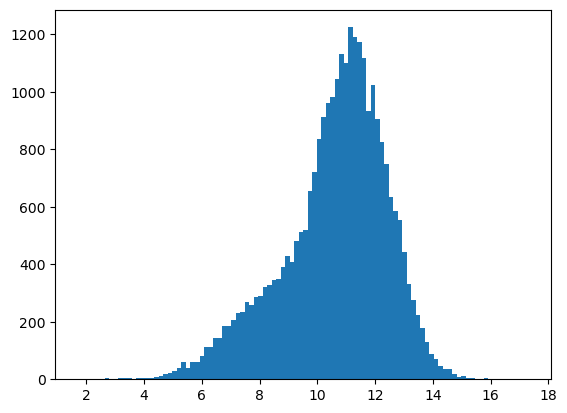

In [ ]:
plt.hist(distances[:,0],bins=100)

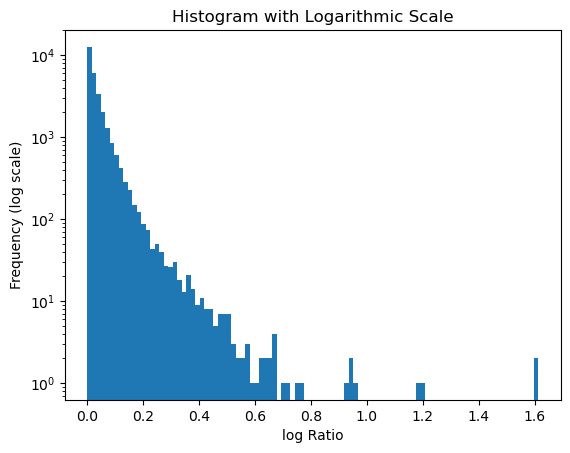

In [ ]:
plt.hist(np.log(ratios[0]), bins=100, log=True)  # Use your actual data instead of ratios[0]
plt.xlabel('log mu')
plt.ylabel('Frequency (log scale)')
plt.title('Histogram with Logarithmic Scale')
plt.show()

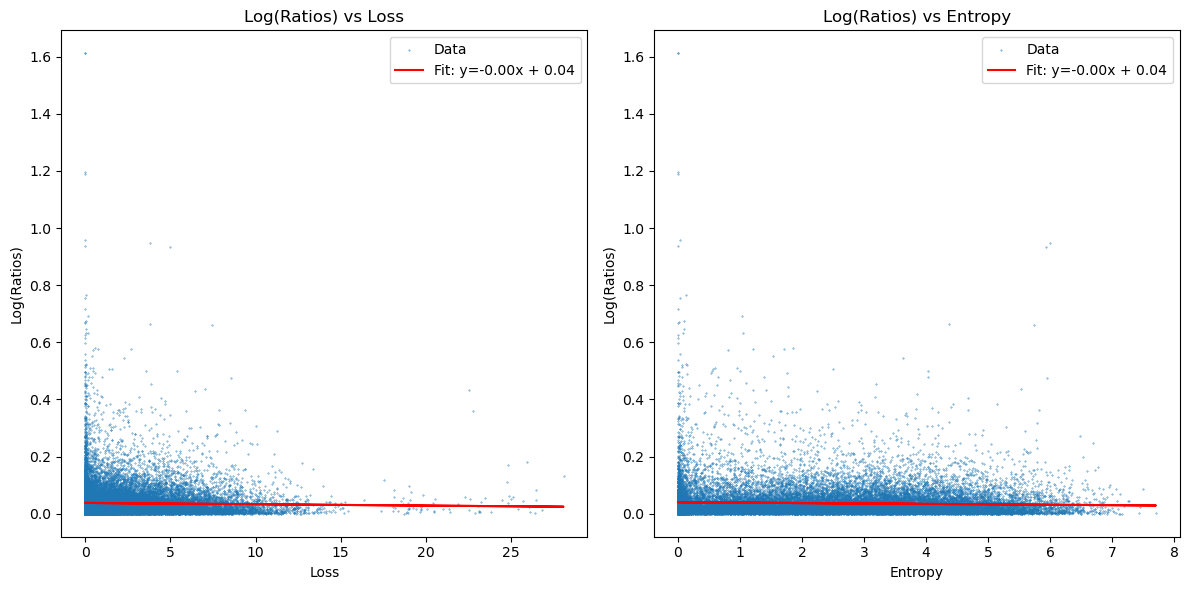

In [ ]:
from scipy.stats import linregress

# Calculate mu = np.log(ratios)
mu = np.log(ratios[0])
# Perform linear regression for 'loss' vs mu
slope_loss, intercept_loss, r_value_loss, p_value_loss, std_err_loss = linregress(Data['loss'], mu)

# Perform linear regression for 'entropy' vs mu
slope_entropy, intercept_entropy, r_value_entropy, p_value_entropy, std_err_entropy = linregress(Data['entropy'], mu)

# Plotting 'loss' vs mu with linear fit
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(Data['loss'], mu, label='Data',s=0.1)
plt.plot(Data['loss'], slope_loss * Data['loss'] + intercept_loss, color='red', label=f'Fit: y={slope_loss:.2f}x + {intercept_loss:.2f}')
plt.xlabel('Loss')
plt.ylabel('Log(Ratios)')
plt.title('Log(Ratios) vs Loss')
plt.legend()

# Plotting 'entropy' vs mu with linear fit
plt.subplot(1, 2, 2)
plt.scatter(Data['entropy'], mu, label='Data',s=0.1)
plt.plot(Data['entropy'], slope_entropy * Data['entropy'] + intercept_entropy, color='red', label=f'Fit: y={slope_entropy:.2f}x + {intercept_entropy:.2f}')
plt.xlabel('Entropy')
plt.ylabel('Log(Ratios)')
plt.title('Log(Ratios) vs Entropy')
plt.legend()

plt.tight_layout()
plt.show()

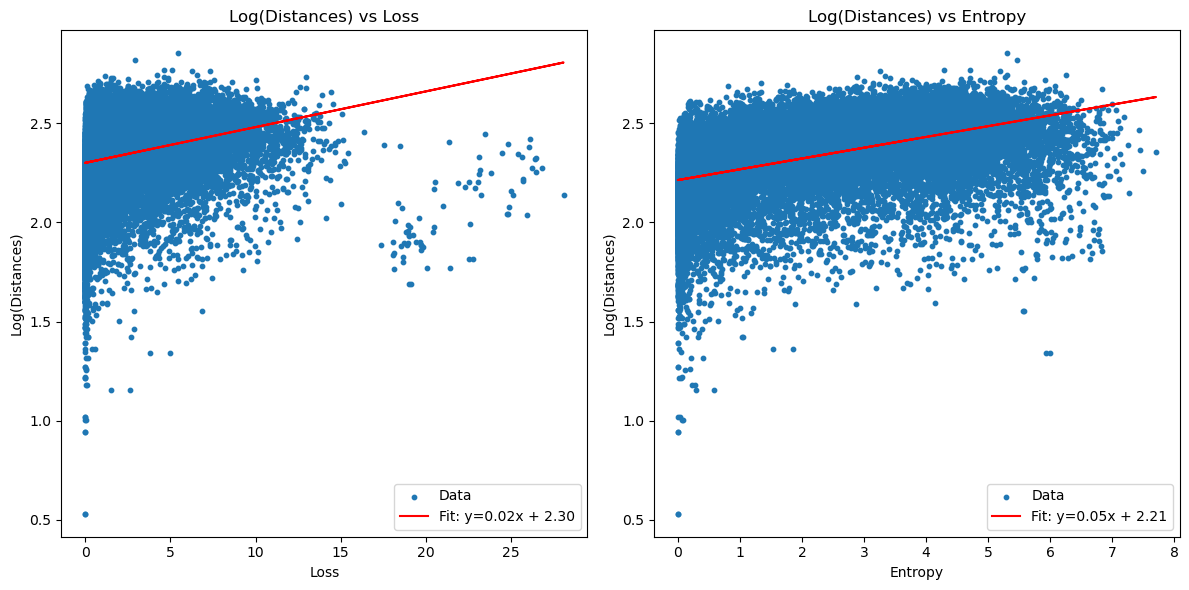

In [ ]:
# Calculate log of distances
log_distances = np.log(distances[:,0])

# Calculate linear regression for 'loss' vs log_distances
slope_loss_log_dist, intercept_loss_log_dist, r_value_loss_log_dist, p_value_loss_log_dist, std_err_loss_log_dist = linregress(Data['loss'], log_distances)

# Calculate linear regression for 'entropy' vs log_distances
slope_entropy_log_dist, intercept_entropy_log_dist, r_value_entropy_log_dist, p_value_entropy_log_dist, std_err_entropy_log_dist = linregress(Data['entropy'], log_distances)

# Plotting 'loss' vs log_distances with linear fit
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(Data['loss'], log_distances, label='Data', s=0.1)
plt.plot(Data['loss'], slope_loss_log_dist * Data['loss'] + intercept_loss_log_dist, color='red', label=f'Fit: y={slope_loss_log_dist:.2f}x + {intercept_loss_log_dist:.2f}')
plt.xlabel('Loss')
plt.ylabel('Log(Distances)')
plt.title('Log(Distances) vs Loss')
plt.legend()

# Plotting 'entropy' vs log_distances with linear fit
plt.subplot(1, 2, 2)
plt.scatter(Data['entropy'], log_distances, label='Data', s=0.1)
plt.plot(Data['entropy'], slope_entropy_log_dist * Data['entropy'] + intercept_entropy_log_dist, color='red', label=f'Fit: y={slope_entropy_log_dist:.2f}x + {intercept_entropy_log_dist:.2f}')
plt.xlabel('Entropy')
plt.ylabel('Log(Distances)')
plt.title('Log(Distances) vs Entropy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:

from utils.load_Datasets import load_Datasets
from utils.load_Model import load_Model
from utils.utils import *
import concurrent.futures


In [ ]:
model, tokenizer = load_Model('olmo-1b', checkpoint='main')


Trying to load model : olmo-7b / checkpoint : main -> from ../Models/OLMo-7B/main


In [ ]:
dataset_name='pile_uncopyrighted_parquet'
dataset_subset=[0]
tokens_min_length=2048*10

dataset = load_Datasets(dataset_config_dict={
        'name': dataset_name,
        'subset': dataset_subset,
        'base_directory': None
    })
print(f"Original dataset size: {len(dataset)}")

def filter_item(index, item, tokenizer, tokens_min_length):
    tokens = tokenizer(item['text'], truncation=False, return_tensors='pt')
    if tokens['input_ids'].shape[1] >= tokens_min_length:
        return index
    return None

def filter_dataset_indices(dataset, tokenizer, tokens_min_length=1024, max_workers=4):
    valid_indices = []
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(filter_item, i, item, tokenizer, tokens_min_length): i for i, item in enumerate(dataset)}
        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            if result is not None:
                valid_indices.append(result)
    valid_indices.sort()
    return valid_indices

valid_indices = filter_dataset_indices(dataset, tokenizer, tokens_min_length=tokens_min_length, max_workers=8)
dataset = dataset.select(valid_indices)
print(f"Filtered dataset size: {len(dataset)}")

Original dataset size: 91777
Filtered dataset size: 552


In [ ]:
dataset

Dataset({
    features: ['text', 'meta', 'id'],
    num_rows: 552
})

In [ ]:
from datasets import Dataset
import pandas as pd

def chunk_dataset_with_tokenizer(dataset, chunk_size=2048, max_chunk_idx=20):
    """
    Chunk the text sequences in the dataset based on a tokenizer and maintain the rest of the 'meta' information.
    
    Parameters:
    dataset (Dataset): The HuggingFace dataset to be chunked.
    tokenizer_name (str): The name of the tokenizer to be used.
    chunk_size (int): The size of each chunk. Default is 2048.
    max_chunk_idx (int): The maximum number of chunks per text. Default is 20.
    
    Returns:
    Dataset: A new HuggingFace dataset with chunked text sequences and updated IDs.
    """

    def chunk_text_with_meta(data, tokenizer, chunk_size, max_chunk_idx):
        tokens = tokenizer.encode(data['text'], truncation=False)
        token_chunks = [tokens[i:i + chunk_size] for i in range(0, len(tokens), chunk_size)]
        token_chunks = token_chunks[:max_chunk_idx]  # Limit to max_chunk_idx
        new_data = []
        for j, chunk in enumerate(token_chunks):
            chunk_text = tokenizer.decode(chunk, skip_special_tokens=True)
            new_entry = {'id': f"{data['id']}-{j}", 'text': chunk_text}
            for key, value in data.items():
                if key not in ['id', 'text']:
                    new_entry[key] = value
            new_data.append(new_entry)
        return new_data

    new_data = []

    for i, data in enumerate(dataset):
        new_data.extend(chunk_text_with_meta(data, tokenizer, chunk_size, max_chunk_idx))

    # Converting list of dictionaries to HuggingFace Dataset
    chunked_dataset = Dataset.from_pandas(pd.DataFrame(new_data))

    return chunked_dataset
chunked_dataset=chunk_dataset_with_tokenizer(dataset, chunk_size=2048, max_chunk_idx=20)

In [ ]:
new_dataset=chunk_dataset_with_tokenizer(dataset, chunk_size=2048, max_chunk_idx=20)

In [ ]:
len(new_dataset)

8453

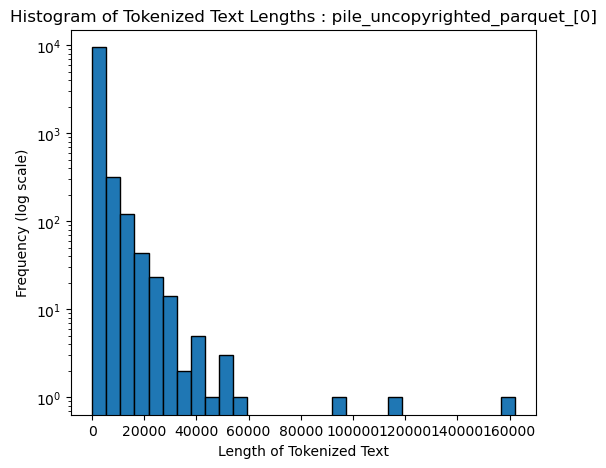

Fraction of texts with length more than 2000: 0.1316
Fraction of texts with length more than 5000: 0.0578
Fraction of texts with length more than 10000: 0.0244
Fraction of texts with length more than 20000: 0.0061
Fraction of texts with length more than 50000: 0.0007


In [ ]:
# Create histogram
plt.figure(figsize=(6, 5))
plt.hist(length, bins=30, edgecolor='black')
plt.title(f'Histogram of Tokenized Text Lengths : {dataset_name}_{dataset_subset}')
plt.xlabel('Length of Tokenized Text')
plt.ylabel('Frequency (log scale)')
plt.yscale('log')
plt.show()
total = len(length)
fractions = {
    "more_than_2000": sum(l > 2000 for l in length) / total,
    "more_than_5000": sum(l > 5000 for l in length) / total,
    "more_than_10000": sum(l > 10000 for l in length) / total,
    "more_than_20000": sum(l > 20000 for l in length) / total,
    "more_than_50000": sum(l > 50000 for l in length) / total
}

# Print fractions
for key, value in fractions.items():
    print(f"Fraction of texts with length {key.replace('_', ' ')}: {value:.4f}")


In [ ]:
total = len(length)
fractions = {
    "more_than_2000": sum(l > 2000 for l in length) / total,
    "more_than_5000": sum(l > 5000 for l in length) / total,
    "more_than_10000": sum(l > 10000 for l in length) / total,
    "more_than_20000": sum(l > 20000 for l in length) / total,
    "more_than_50000": sum(l > 50000 for l in length) / total
}

# Print fractions
for key, value in fractions.items():
    print(f"Fraction of texts with length {key.replace('_', ' ')}: {value:.4f}")


Fraction of texts with length more than 2000: 0.1316
Fraction of texts with length more than 5000: 0.0578
Fraction of texts with length more than 10000: 0.0244
Fraction of texts with length more than 20000: 0.0061
Fraction of texts with length more than 50000: 0.0007
